In [1]:
import pickle
import dataclasses
import pathlib
import os
import sys
import yourdfpy
import numpy as np
import trimesh
import open3d as o3d

# sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
# # sys.path.append(os.path.join(os.path.dirname(__file__), '..'))
# from ..legged_env.assets.urdf_util import scene_to_vf,vf_to_mesh

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")

@dataclasses.dataclass
class Offspring:
    model_dir: str = None
    cmd: str = None
    run_dir: str = None
    reward: float = None
    evaluated: bool = False
    generation: int = None
    checkpoint_file: str = None
    parents: list = dataclasses.field(default_factory=list)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def vf_to_mesh(vertices, faces, return_type="o3d"):
    """Converts vertex and face arrays into a mesh object.

    Args:
        vertices: NumPy array (n, 3) of vertex coordinates.
        faces: NumPy array (m, 3) of vertex indices forming triangles.
        return_type: The type of mesh object to return ("o3d" for Open3D, "trimesh" for Trimesh). Defaults to "o3d".

    Returns:
        The mesh object of the specified type:
            - open3d.geometry.TriangleMesh if `return_type` is "o3d".
            - trimesh.Trimesh if `return_type` is "trimesh".

    Raises:
        ValueError: If `return_type` is not "o3d" or "trimesh".
    """
    if return_type == "o3d":
        return o3d.geometry.TriangleMesh(
            vertices=o3d.utility.Vector3dVector(vertices),
            triangles=o3d.utility.Vector3iVector(faces),
        )
    elif return_type == "trimesh":
        return trimesh.Trimesh(vertices=vertices, faces=faces)
    else:
        raise ValueError("Invalid return_type. Choose 'o3d' or 'trimesh'.")
    
def scene_to_vf(scene: trimesh.Scene):
    """Extracts and transforms vertices and faces from a trimesh Scene.

    Args:
        scene: The trimesh.Scene object to process.

    Returns:
        Tuple (vertices, faces):
            - vertices: NumPy array (num_vertices, 3) of transformed vertex coordinates.
            - faces: NumPy array (num_faces, 3) of vertex indices.

    Example:
        ```python
        import yourdfpy

        urdf = yourdfpy.URDF.load(...)  
        scene = get_urdf_scene(urdf) 
        vertices, faces = scene_to_vf(scene)  
        mesh = vf_to_mesh(vertices, faces, return_type="o3d")
        o3d.visualization.draw_geometries([mesh])  # Visualize using Open3D
        ```
    """
    vertices_list = []
    faces_list = []
    offset = 0

    for node_name in scene.graph.nodes_geometry:
        # Get transform and geometry for the current node
        transform, geometry_name = scene.graph[node_name]
        geometry = scene.geometry[geometry_name]

        # Skip if geometry doesn't have triangles
        if not hasattr(geometry, "triangles"):
            continue

        # Apply transform to vertices and append to list
        transformed_vertices = trimesh.transformations.transform_points(
            geometry.vertices.copy(), matrix=transform
        )
        vertices_list.append(transformed_vertices)

        # Append face indices with offset and update offset
        faces_list.append(geometry.faces + offset)
        offset += geometry.vertices.shape[0]

    # Stack vertices and faces into single arrays
    vertices = np.vstack(vertices_list)
    faces = np.vstack(faces_list)
    return vertices, faces


In [3]:
# ser-02
pickle_path = "/home/bx35/repo/RobotsMakingRobots/evolutionary_loop/Experiment_2/Offspring_2024-05-17_14-16-30/log_files/generation_68.pkl"
base_dir = "/home/bx35/repo/RobotsMakingRobots/evolutionary_loop"
num_samples = 10000

with open(pickle_path,"rb") as file:
        generation_dict = pickle.load(file)
        

for name,robot in generation_dict.items():
    urdf_path = next(pathlib.Path(os.path.join(base_dir,robot.model_dir)).rglob("*.urdf"))
    robot.urdf = yourdfpy.URDF.load(str(urdf_path))
    robot.vertices, robot.faces = scene_to_vf(robot.urdf.scene)
    robot.mesh = vf_to_mesh(robot.vertices, robot.faces,return_type='o3d')
    
    robot.pcd = robot.mesh.sample_points_uniformly(number_of_points=num_samples) # long running code
    robot.pcd_distance = dict()
    robot.chamfer_distance = dict()
    # break

for name,robot in generation_dict.items():
    for other_name,other_robot in generation_dict.items():
        if other_name!=name and robot.generation==other_robot.generation:
            robot.pcd_distance[other_name] = np.asarray(robot.pcd.compute_point_cloud_distance(other_robot.pcd)).mean()
            
for name,robot in generation_dict.items():
    for other_name,other_robot in generation_dict.items():
        if other_name!=name and robot.generation==other_robot.generation: # TODO: CHECK generation is the current generation of the robot
            robot.chamfer_distance[other_name] = ( robot.pcd_distance[other_name] +  
                                                other_robot.pcd_distance[name])*0.5 
for name,robot in generation_dict.items():
    robot.chamfer_distance_mean=np.mean(np.fromiter(robot.chamfer_distance.values(),dtype=float)) # chamfer_distance_mean
    
    
keys = list(filter(lambda x:not x.startswith("__"),next(iter(generation_dict.values())).__dict__.keys()))
# keys+=["chamfer_distance_mean"]

flat_generation_dict ={
    key:[robot.__dict__[key] for robot in generation_dict.values()] 
    for key in keys
    }
flat_generation_dict["name"] = list(generation_dict.keys())

df = pd.DataFrame(flat_generation_dict)


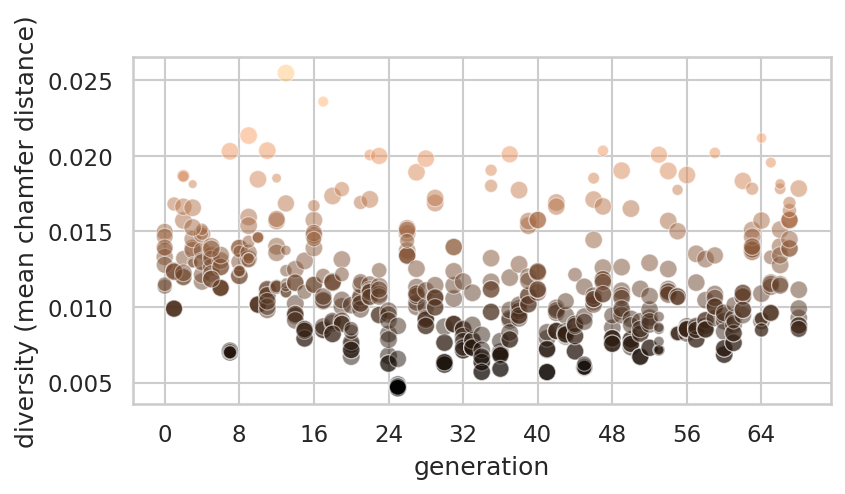

In [4]:
ax = plt.figure(figsize=(6,3),dpi=150).gca()
# https://matplotlib.org/stable/users/explain/colors/colormaps.html
sns.scatterplot(df,x="generation",y="chamfer_distance_mean",hue='chamfer_distance_mean',palette='copper',legend=None,size='reward',alpha=0.5) #legend=None
ax.set_ylabel("diversity (mean chamfer distance)")
from matplotlib.ticker import MaxNLocator
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
# plt.xticks(range(0,num_generation+1,2))

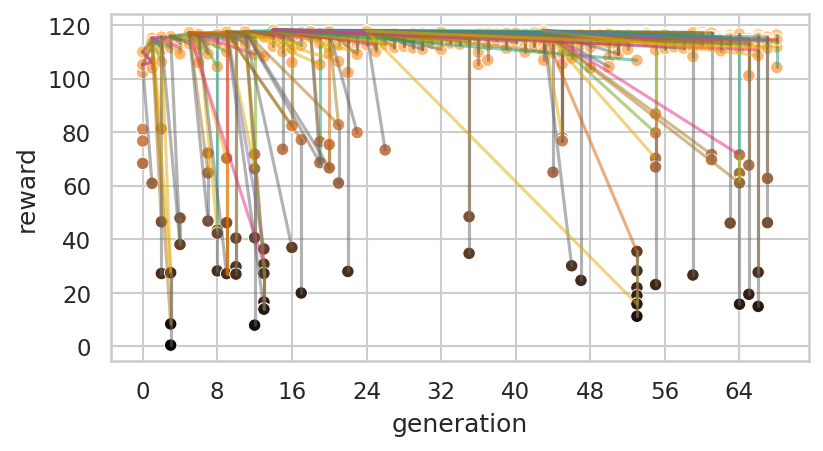

In [8]:
cmap = plt.get_cmap('Dark2')

connectivity = []
for i,(name,robot) in enumerate(generation_dict.items()):
    # if len(robot.parents)==2:
    for parent in robot.parents:
        # if robot.reward>=parent.reward and robot.generation>parent.generation:
        # if robot.generation>parent.generation:
        connectivity.append([[parent.generation,robot.generation],[parent.reward,robot.reward],cmap((i%cmap.N)/cmap.N)])
        # print(parent.reward)
    # break

# connectivity = []
# for name,robot in generation_dict.items():
#         for other_name,other_robot in generation_dict.items():
#             if other_name==name and robot.generation==other_robot.generation+1:
#                 connectivity.append([[other_robot.generation,robot.generation],[other_robot.reward,robot.reward]])



ax = plt.figure(figsize=(6,3),dpi=150).gca()

for c in connectivity:
    ax.plot(c[0],c[1],color=c[2],alpha=0.5)
    
# https://matplotlib.org/stable/users/explain/colors/colormaps.html
sns.scatterplot(df,x="generation",y="reward",hue='reward',palette='copper',legend=None)
from matplotlib.ticker import MaxNLocator
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
# plt.xticks(range(0,num_generation+1,2))




7

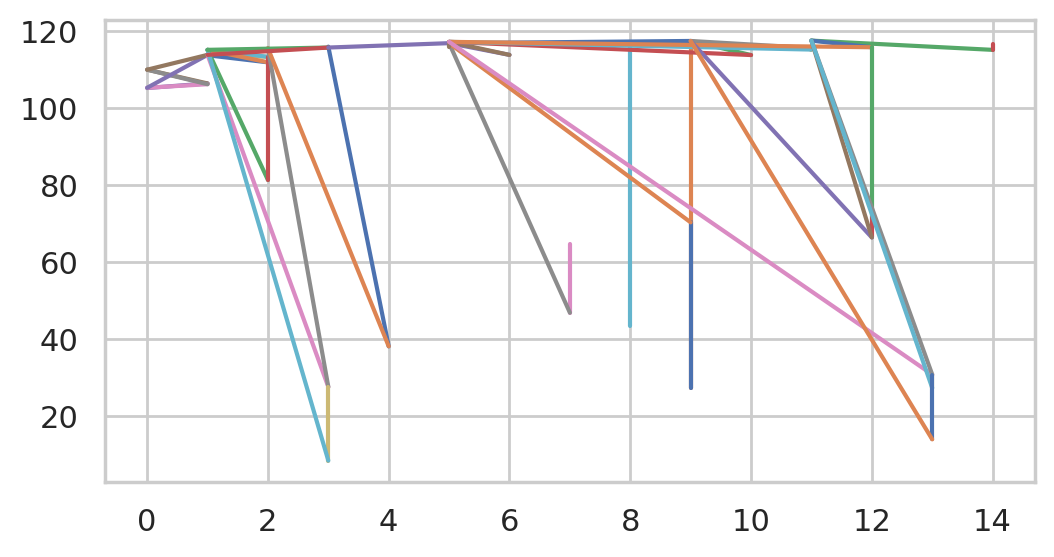

In [25]:
connectivity
ax = plt.figure(figsize=(6,3),dpi=200).gca()
for c in connectivity:
    ax.plot(*c)